In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import os
import datetime
import numpy as np
import pandas as pd
import warnings
import network
import split_extract
from multiprocessing import Pool
from tqdm import tqdm
from params import dresden_images_root, dresden_csv, ins_root, ins_csv, patch_span, \
        patch_num, ins_patches, ins_patches_db, ins_test
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [4]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./instance/model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./instance/patches/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

Found 2976 images belonging to 3 classes.


In [5]:
print('\n# Evaluate on test data')
results = model.evaluate(test_generator)
print('test loss, test acc:', results)


# Evaluate on test data
47/47 [==============================] - 10s 210ms/step - loss: 0.0954 - accuracy: 0.9814
test loss, test acc: [0.09535113160320102, 0.98140675]


In [6]:
warnings.filterwarnings("ignore")

if not os.path.exists(ins_test):
    os.makedirs(ins_test)
        
data = pd.read_csv(dresden_csv)
data = data[(data['brand'] == 'Canon') & (data['instance'] != 0)]

In [7]:
brand_model = ['_'.join([brand, model]) for brand, model in zip(data['brand'],data['model'])]

print('Collecting image data...')
imgs_list = []

for img_brand_model, img_path in \
    tqdm(zip(brand_model, data['filename'])):
        imgs_list += [{'data_set':'patches',
                           'img_path':img_path,
                           'img_brand_model':img_brand_model,
                           'patch_span':patch_span,
                           'patch_num':patch_num,
                           'patch_root': ins_test,
                           'img_root': dresden_images_root
                           }]
# num_processes = 12
num_processes = 4
pool = Pool(processes=num_processes)
test_paths = pool.map(split_extract.extract, imgs_list)
print('Completed.')

380it [00:00, 226622.43it/s]

Completed.


In [8]:
# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./instance/test/patches/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

print('\n# Evaluate on test data')
results = model.evaluate(test_generator)

Found 9500 images belonging to 1 classes.

# Evaluate on test data
149/149 [==============================] - 22s 145ms/step - loss: 7.8532 - accuracy: 0.3331


Found 9500 images belonging to 1 classes.
              Canon_Ixus55  Canon_Ixus70  Canon_PowerShotA640
Canon_Ixus70            54          4415                   11


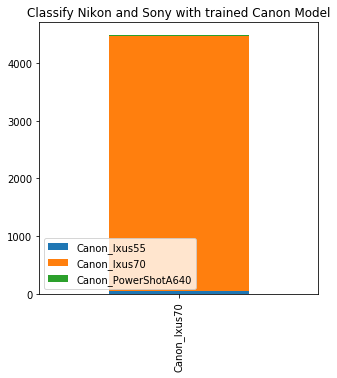

In [9]:
# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./instance/test/patches/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

df1 = pd.read_csv(ins_csv)
test_model = os.listdir(os.path.join(ins_test, 'patches'))
model_list = np.unique(df1['brand_model'])

# generate a histogram, which for every unseen models, how many imgs are classified.
hist = [[0, 0, 0] for i in range(len(test_model))]

for i in range(70):
    gen = next(test_generator)
    pred = model.predict(gen[0])
    pred_labels = np.argmax(pred, axis=1)
    real_labels = np.argmax(gen[1], axis=1)
    for j in range(len(pred_labels)):
        hist[real_labels[j]][pred_labels[j]] += 1

        
df = pd.DataFrame(hist, index=test_model, columns=model_list)
print(df)

df.plot.bar(stacked=True, figsize=(5, 5), title='Classify Nikon and Sony with trained Canon Model')